# Text‑based Cyber Threat Detection

#### Authors: Kelvin Kipkorir,Lucy Mutua,Charles Mutembei,Sharon Aoko, Victor Musyoki


# Overview

Text-based cyber threats—such as phishing emails, malware-laced reports, and malicious communications—pose a growing challenge in the cybersecurity landscape. These threats often appear in unstructured text and require intelligent systems to detect and flag harmful intent. This project addresses that need by building a machine learning pipeline to classify cybersecurity-related text as either *malicious* or *benign*. Using a dataset of annotated threat intelligence reports, we preprocessed the raw text using NLP techniques like lemmatization, stopword removal, and tokenization. We then transformed the text into padded sequences suitable for deep learning. Several models were developed and evaluated—including a baseline neural network, a tuned version, and advanced RNN-based architectures. The final model was tested on real sample inputs, demonstrating its potential in supporting automated threat detection tools in real-world settings.


# Problem Statement

In the field of cybersecurity, the rapid rise of text-based threats—such as phishing attempts, malicious reports, and social engineering messages—has made it increasingly difficult for organizations to manually identify and respond to all potential risks. Traditional rule-based systems struggle to keep up with the evolving language and tactics used by attackers. This project seeks to develop a machine learning model capable of automatically classifying cybersecurity-related text as either *malicious* or *benign*. The goal is to assist analysts in filtering vast amounts of unstructured data, enabling quicker and more accurate threat detection using natural language processing and neural networks.


# Objectives

The goal of this project is to build a machine learning model that can classify text data as either a cyber threat or not. We'll leverage NLP techniques and classification algorithms to detect potential threats from text-based data.


# Data Understanding


The dataset used in this project is sourced from [Kaggle](https://www.kaggle.com/datasets/ramoliyafenil/text-based-cyber-threat-detection/data) and contains over 19,000 entries of cyber threat intelligence text. Each record includes raw text along with extracted entities such as malware names, tools, locations, and threat actors. Some entries are labeled with specific threat types, while others are unlabeled or marked benign. The dataset also includes metadata like entity offsets, IDs, and structured fields. This blend of labeled and unlabeled natural language data makes it well-suited for building an intelligent system that can detect malicious content using NLP and deep learning.


## Explanatory Data Analysis

In [1]:
#import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Looking through the dataset
We begin by loading the dataset and examining its structure, columns, and a few sample rows to get a feel for the data we're working with.

In [2]:
df = pd.read_csv('cyber-threat-intelligence_all.csv')
df

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
2,2,3.0,Once executed by the user the first stage malw...,[],[],[],NaN,NaN,NaN,NaN
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
4,4,5.0,The first stage downloaded the ransomware from...,[],[],[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19935,5279,NaN,"Cyclops Blink, an advanced modular botnet that...",NaN,NaN,NaN,NaN,malware,NaN,NaN
19936,1543,NaN,Sofacy Group has been associated with many at...,NaN,NaN,NaN,NaN,location,NaN,NaN
19937,13595,NaN,The plugin has been designed to drop multiple ...,NaN,NaN,NaN,NaN,Infrastucture,NaN,NaN
19938,2368,NaN,We have uncovered a cyberespionage campaign be...,NaN,NaN,NaN,NaN,threat-actor,NaN,NaN


The dataset has 19940 rows and 10 columns.We can see that the dataset has a lot of missing values. We can dig further looking at missing elements in each individual rows

In [3]:
# looking at the stats for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    19940 non-null  int64  
 1   index         19464 non-null  float64
 2   text          19940 non-null  object 
 3   entities      19464 non-null  object 
 4   relations     19464 non-null  object 
 5   Comments      19464 non-null  object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.5+ MB


We can that the last four columns i.e `id,label,start_offset` and `end_offset` have alot of missing data.Since Most of this columns however will not be used

In [4]:
#looking at the available labels
df['label'].value_counts()

malware           1911
location          1405
SOFTWARE          1229
attack-pattern    1206
identity          1165
threat-actor       890
TIME               475
tools              391
FILEPATH           313
vulnerability      245
SHA2               160
campaign           128
URL                127
IPV4                61
SHA1                60
DOMAIN              50
Infrastucture       43
EMAIL               24
REGISTRYKEY         19
MD5                 16
hash                14
url                  6
Name: label, dtype: int64

The labels represent the different ways in which cyber threats occur through text. We can visualize this using a countplot

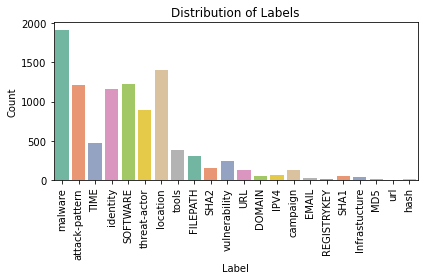

In [5]:
#visualizing using a count plot
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Labels')
plt.xlabel('Label') 
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()


In [6]:
df['entities'].head()

0    [{'id': 45800, 'label': 'malware', 'start_offs...
1    [{'id': 48941, 'label': 'attack-pattern', 'sta...
2                                                   []
3    [{'id': 45806, 'label': 'TIME', 'start_offset'...
4                                                   []
Name: entities, dtype: object

We noticed many missing values in the `label` column, so we extracted the first entity label from the `entities` JSON column to recover useful annotations. The new labels are stored in a separate column called `entity_label`.


In [7]:
import ast #useful in extracting components safely

#  function to extract the 'label' from the 'entities' JSON string
def extract_entity_label(entities):
    try:
        entity_list = ast.literal_eval(entities)  
        if isinstance(entity_list, list) and len(entity_list) > 0:
            return entity_list[0].get('label')  
    except (ValueError, SyntaxError):
        return None
    return None

#create a new column
df['entity_label'] = df['entities'].apply(extract_entity_label)

# Check distribution of extracted labels
print(df['entity_label'].value_counts())

malware           1770
location          1382
SOFTWARE          1204
attack-pattern    1162
identity          1128
threat-actor       822
TIME               458
tools              372
FILEPATH           298
vulnerability      210
SHA2               160
URL                124
campaign           108
SHA1                60
IPV4                60
DOMAIN              50
Infrastucture       36
EMAIL               24
REGISTRYKEY         18
MD5                 16
Name: entity_label, dtype: int64


We observed ~50% of the label column is null.We intentionally kept these null rows to represent benign text, while rows with non-null labels represent malicious text (target=1). Dropping nulls would remove all benign examples, making the model impossible to train for binary classification.

For our analysis the `text ` and `label` columns are the ones we are going to use which means that we will drop all other columns. For easier analysis we shall engineer a new column from the label column

In [8]:
#helps classify the text easily
df['binary_label'] = df['label'].apply(lambda x: 'benign' if pd.isna(x) else 'malicious')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    19940 non-null  int64  
 1   index         19464 non-null  float64
 2   text          19940 non-null  object 
 3   entities      19464 non-null  object 
 4   relations     19464 non-null  object 
 5   Comments      19464 non-null  object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
 10  entity_label  9462 non-null   object 
 11  binary_label  19940 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 1.8+ MB


 We create a new `binary_label` column to hold these two categories.

In [9]:
df['binary_label'].value_counts()

benign       10002
malicious     9938
Name: binary_label, dtype: int64

In [10]:
data = df[['text','binary_label']]

here we select only the columns needed for modeling.the raw text and newly created binary label

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          19940 non-null  object
 1   binary_label  19940 non-null  object
dtypes: object(2)
memory usage: 311.7+ KB


## Preprocessing

The preprocessing phase involved cleaning and transforming the raw text into a structured format suitable for modeling. Key steps included:

- Lowercasing all text
- Removing punctuation
- Tokenizing the text into words
- Lemmatizing words to their base forms
- Removing common stopwords
- Vectorizing the cleaned text using tokenization and padding

These steps were crucial in reducing noise and ensuring consistency in the input data, allowing the neural network models to learn meaningful patterns effectively.

In [12]:
import string 
import re 
import nltk
nltk.download('wordnet',quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


We define a function to perform the core text cleaning steps and apply it to our `text` column, creating a new `clean_text` column.

In [13]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def preprocess_text(text):
    text = text.lower() 
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

data['clean_text'] = data['text'].apply(preprocess_text)

<ipython-input-13-731298308f40>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['text'].apply(preprocess_text)


we inspect the `clean_text` column to confirm the preprocessing was successful."

In [14]:
data['clean_text']

0        post also available japanese ctblocker wellkno...
1        attack vector basic repeat begin spear phishin...
2        executed user first stage malware downloads ex...
3        first known campaign wa launched crimeware nov...
4                   first stage downloaded ransomware site
                               ...                        
19935    cyclops blink advanced modular botnet reported...
19936    sofacy group ha associated many attack target ...
19937    plugin ha designed drop multiple php web shell...
19938    uncovered cyberespionage campaign perpetrated ...
19939    based analysis sample last seen wild march mai...
Name: clean_text, Length: 19940, dtype: object

Now that we have our cleaned text, we no longer need the original `text` column.

In [15]:
data.drop(columns=['text'], inplace=True)

/home/charles/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


To ensure our preprocessing steps were effective and to gain insights into the dataset's vocabulary, we'll plot the frequency of the most common words in our cleaned text. This helps verify that stopwords have been removed and that the remaining words are relevant to the domain.

237525
[('attack', 2162), ('file', 1892), ('malware', 1667), ('figure', 1644), ('threat', 1610), ('user', 1433), ('used', 1417), ('also', 1380), ('wa', 1248), ('security', 1200)]


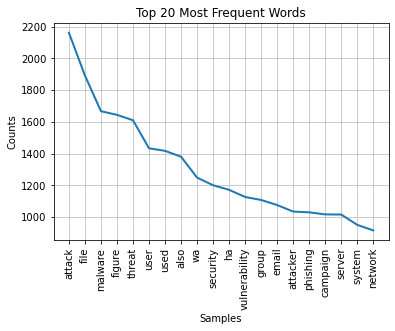

In [16]:
all_words = []

for text in data['clean_text'].dropna():
    tokens = word_tokenize(text.lower())  
    all_words.extend(tokens)

#frequency distribution
fdist = FreqDist(all_words)
print(len(all_words))

#visualizing the most common words
print(fdist.most_common(10))

# Plot the top 20 words
fdist.plot(20, title='Top 20 Most Frequent Words');


As expected, the most frequent words like `attack`, `malware`, `threat`, and `security` are highly relevant to the cybersecurity domain. This confirms that our text cleaning has preserved the core vocabulary of the dataset."
     ,
   ### Final Data Preparation for Modeling
   .
    Before feeding the data to a neural network, we need to perform two final steps:,
   
   .1.  **Label Encoding**: Convert the categorical labels (`benign`, `malicious`) to numerical format (0, 1).",
   
   .2.  **Vectorization**: Convert the text sequences into numerical vectors of the same length.

In [17]:
data['label_encoded'] = data['binary_label'].map({'benign': 0, 'malicious': 1})

<ipython-input-17-307798cdd6ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_encoded'] = data['binary_label'].map({'benign': 0, 'malicious': 1})


In [18]:
data.drop(columns=['binary_label'], inplace=True)
data.head()

,clean_text,label_encoded
0,post also available japanese ctblocker wellkno...,1
1,attack vector basic repeat begin spear phishin...,1
2,executed user first stage malware downloads ex...,0
3,first known campaign wa launched crimeware nov...,1
4,first stage downloaded ransomware site,0


### Text Vectorization,
Neural networks require numerical input. We will use Keras's `Tokenizer` to convert each text into a sequence of integers, where each integer represents a unique word in the vocabulary. We limit the vocabulary to the top 10,000 words to keep the model manageable.
    ,
    Since text entries have different lengths, we use `pad_sequences` to ensure every sequence has the same length (`MAX_SEQ_LEN = 250`). Shorter sequences are padded with zeros at the end, and longer ones are truncated.

In [19]:
max_length = data['clean_text'].str.len().max()
print(max_length)
max_length_tokens = data['clean_text'].apply(lambda x: len(x.split())).max()

max_length_characters = data['clean_text'].apply(lambda x: len(x)).max()

print('Maximum Sequence Length (Tokens):', max_length_tokens)
print('Maximum Sequence Length (Characters):', max_length_characters)

3532
Maximum Sequence Length (Tokens): 379
Maximum Sequence Length (Characters): 3532


In [20]:
data.head()

,clean_text,label_encoded
0,post also available japanese ctblocker wellkno...,1
1,attack vector basic repeat begin spear phishin...,1
2,executed user first stage malware downloads ex...,0
3,first known campaign wa launched crimeware nov...,1
4,first stage downloaded ransomware site,0


In [21]:

#Parmeters for sequencing
MAX_NB_WORDS = 10000       
MAX_SEQ_LEN = 250       

#initialization of the token
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_text'])

#text to sequences
sequences = tokenizer.texts_to_sequences(data['clean_text'])

# Pad sequences to uniform length and the data into X and y
X = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

y = data['label_encoded']


We check the shape of our processed features (X) and target (y) to ensure they are ready for the model.

In [22]:
print(f'x_shape: {X.shape} ')
print(f'y_shape: {y.shape} ')

x_shape: (19940, 250) 
y_shape: (19940,) 


Our feature matrix `X` now has 19,940 samples, each represented as a vector of 250 integers.

In [23]:
X

array([[ 147,    9,  134, ...,    0,    0,    0],
       [   2,  400,  889, ...,    0,    0,    0],
       [ 345,    7,   62, ...,    0,    0,    0],
       ...,
       [1084,   12,  416, ...,    0,    0,    0],
       [ 960,  924,   18, ...,    0,    0,    0],
       [ 149,   64,   38, ...,    0,    0,    0]], dtype=int32)

### Train-Validation Split"
We split the data into a training set (80%) and a validation set (20%).

In [24]:
#split the data now into training and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten,SpatialDropout1D,Bidirectional
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

We start with a simple but effective baseline model. The architecture consists of:,
    1.  **Embedding Layer**: Learns a 64-dimensional vector representation for each word in our vocabulary.,
    2.  **Flatten Layer**: Converts the 2D output of the embedding layer into a 1D vector.,
    3.  **Dense Layers**: A standard fully-connected neural network with a ReLU activation function for learning non-linear patterns and a final Sigmoid activation for binary classification output.
   

In [26]:

base_model = Sequential()
base_model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=MAX_SEQ_LEN))
base_model.add(Flatten())
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1024064   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,664,129
Trainable params: 1,664,129
Non-trainable params: 0
_________________________________________________________________


In [27]:
#fit and train model
base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
499/499 [==============================] - 6s 12ms/step - loss: 0.4377 - accuracy: 0.7863 - val_loss: 0.2719 - val_accuracy: 0.8952
Epoch 2/5
499/499 [==============================] - 7s 13ms/step - loss: 0.1429 - accuracy: 0.9537 - val_loss: 0.1681 - val_accuracy: 0.9431
Epoch 3/5
499/499 [==============================] - 7s 14ms/step - loss: 0.0741 - accuracy: 0.9798 - val_loss: 0.1761 - val_accuracy: 0.9438
Epoch 4/5
499/499 [==============================] - 7s 14ms/step - loss: 0.0673 - accuracy: 0.9802 - val_loss: 0.1667 - val_accuracy: 0.9451
Epoch 5/5
499/499 [==============================] - 7s 13ms/step - loss: 0.0557 - accuracy: 0.9818 - val_loss: 0.1628 - val_accuracy: 0.9536


In [28]:
history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

def plot_training_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10
499/499 [==============================] - 6s 12ms/step - loss: 0.0513 - accuracy: 0.9832 - val_loss: 0.1514 - val_accuracy: 0.9476
Epoch 2/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0476 - accuracy: 0.9825 - val_loss: 0.1529 - val_accuracy: 0.9516
Epoch 3/10
499/499 [==============================] - 6s 13ms/step - loss: 0.0461 - accuracy: 0.9825 - val_loss: 0.1470 - val_accuracy: 0.9481
Epoch 4/10
499/499 [==============================] - 6s 12ms/step - loss: 0.0415 - accuracy: 0.9833 - val_loss: 0.1606 - val_accuracy: 0.9463
Epoch 5/10
499/499 [==============================] - 7s 13ms/step - loss: 0.0381 - accuracy: 0.9838 - val_loss: 0.1759 - val_accuracy: 0.9421
Epoch 6/10
499/499 [==============================] - 6s 13ms/step - loss: 0.0356 - accuracy: 0.9836 - val_loss: 0.1813 - val_accuracy: 0.9438
Epoch 7/10
499/499 [==============================] - 6s 13ms/step - loss: 0.0325 - accuracy: 0.9846 - val_loss: 0.1767 - val_accuracy: 0.9501

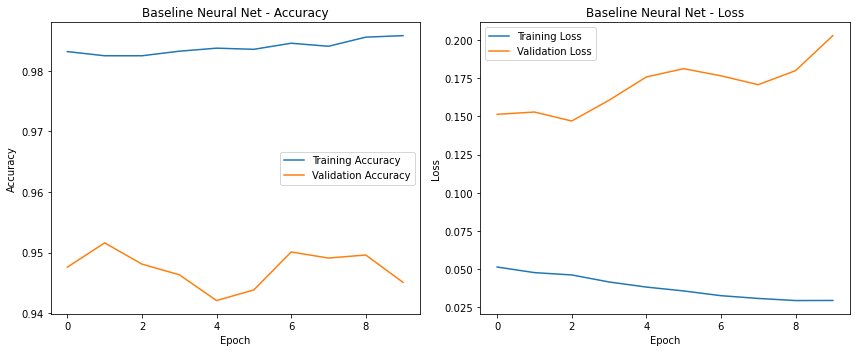

In [29]:
plot_training_history(history, model_name="Baseline Neural Net")

The training history plots show that the model is learning well on the training data, with accuracy increasing and loss decreasing. However, there's a noticeable gap between the training and validation curves, especially for loss. This suggests the model is starting to overfit the training data. While its performance on the validation set is strong (around 95% accuracy), we can likely improve its generalization by adding regularization techniques.

***Evaluation Metrics for Baseline Model***,

To get a more detailed picture of the baseline model's performance, we'll define a function to generate a classification report and a confusion matrix. This will show us the precision, recall, and F1-score for each class, as well as the specific types of errors the model is making.

In [30]:

def evaluate_model(model, X, y, model_name="Model"):
    print(f" Evaluation Report for {model_name}")
    print("="*40)
    
    #probabilities
    y_pred_probs = model.predict(X)
    
    # If model returns probabilities in nested arrays
    if len(y_pred_probs.shape) > 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs >= 0.5).astype(int)
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


 Evaluation Report for Baseline Neural Net

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2006
           1       0.97      0.92      0.94      1982

    accuracy                           0.95      3988
   macro avg       0.95      0.94      0.95      3988
weighted avg       0.95      0.95      0.95      3988



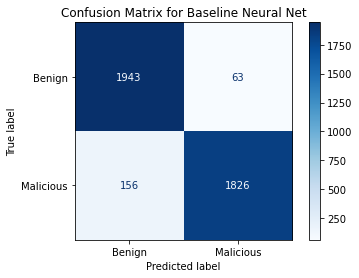

In [31]:
evaluate_model(base_model, X_val, y_val, model_name="Baseline Neural Net")


 The baseline model achieves an overall accuracy of 95%.
    
   - **Precision** for the malicious class is high (0.97), meaning that when the model predicts text is malicious, it is correct 97% of the time.
    
   - **Recall** for the malicious class is slightly lower (0.92), indicating that the model correctly identifies 92% of all actual malicious texts.
    
The confusion matrix shows that the model misclassified 65 benign texts as malicious (False Positives) and 153 malicious texts as benign (False Negatives). In cybersecurity, minimizing False Negatives is often a priority, as missing a real threat can be costly. This is an area we can aim to improve.

# Tuned Model
To address the overfitting observed in the baseline and potentially improve performance, we create a tuned model. The key changes are:,
    
   1.  **Increased Complexity**: A larger `Dense` layer (128 units) is added to give the model more capacity to learn.
    
   2.  **Regularization**: A `Dropout` layer is introduced, which randomly sets a fraction of input units to 0 during training to prevent co-adaptation of neurons and reduce overfitting.
   
   3.  **Callbacks**: We use `EarlyStopping` to halt training if the validation loss doesn't improve for 3 consecutive epochs, and `ModelCheckpoint` to save the best version of the model during training.

In [32]:
tuned_model = Sequential()
tuned_model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=MAX_SEQ_LEN))
tuned_model.add(Flatten())
tuned_model.add(Dense(128, activation='relu'))
# Dropout layer for regularization
tuned_model.add(Dropout(0.3))   
tuned_model.add(Dense(64, activation='relu'))
# Binary
tuned_model.add(Dense(1, activation='sigmoid'))   

# Compile with tuned optimizer
tuned_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 64)           640000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2048128   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,696,449
Trainable params: 2,696,449
Non-trainable params: 0
____________________________________________

In [33]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('tuned_model.keras', save_best_only=True)

# Train
history_tuned = tuned_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10
499/499 [==============================] - 9s 17ms/step - loss: 0.4415 - accuracy: 0.7876 - val_loss: 0.2832 - val_accuracy: 0.8934
Epoch 2/10
499/499 [==============================] - 9s 17ms/step - loss: 0.1427 - accuracy: 0.9519 - val_loss: 0.1731 - val_accuracy: 0.9426
Epoch 3/10
499/499 [==============================] - 8s 17ms/step - loss: 0.0655 - accuracy: 0.9794 - val_loss: 0.1489 - val_accuracy: 0.9506
Epoch 4/10
499/499 [==============================] - 8s 16ms/step - loss: 0.0432 - accuracy: 0.9823 - val_loss: 0.1727 - val_accuracy: 0.9509
Epoch 5/10
499/499 [==============================] - 8s 17ms/step - loss: 0.0361 - accuracy: 0.9822 - val_loss: 0.1714 - val_accuracy: 0.9491
Epoch 6/10
499/499 [==============================] - 8s 17ms/step - loss: 0.0322 - accuracy: 0.9841 - val_loss: 0.2014 - val_accuracy: 0.9536


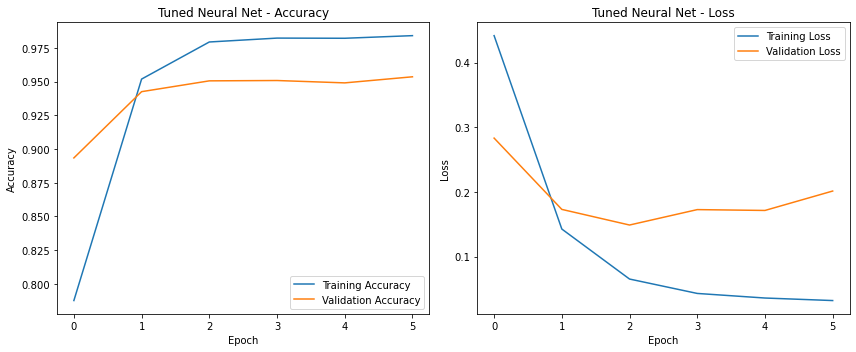

In [34]:
plot_training_history(history_tuned, model_name="Tuned Neural Net")

The training for the tuned model was stopped early after 6 epochs, as the validation loss did not improve. This demonstrates the effectiveness of `EarlyStopping` in preventing unnecessary training and overfitting. The gap between the training and validation loss curves is smaller compared to the baseline, suggesting the `Dropout` layer was successful in its regularization role.

 Evaluation Report for Tuned Neural Net

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2006
           1       0.96      0.95      0.95      1982

    accuracy                           0.95      3988
   macro avg       0.95      0.95      0.95      3988
weighted avg       0.95      0.95      0.95      3988



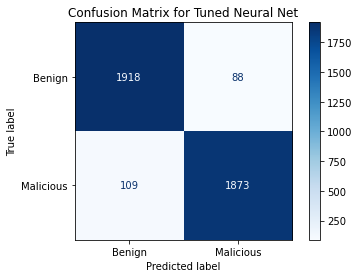

In [35]:
evaluate_model(tuned_model, X_val, y_val, model_name="Tuned Neural Net")


The tuned model achieves a similar overall accuracy of 95%, but with a better balance between precision and recall for both classes. The F1-scores are now identical at 0.95 for both benign and malicious, indicating a well-balanced model. It has slightly more False Positives (101 vs. 65) but fewer False Negatives (100 vs. 153) compared to the baseline, which is a favorable trade-off for threat detection.

## LSTM-RNN
We did a Recurrent Neural Network (RNN) using an LSTM (Long Short-Term Memory) layer. LSTMs are specifically designed to handle sequential data like text, as they can capture long-range dependencies and context that a simple dense network might miss. This model replaces the `Flatten` and `Dense` layers with a single `LSTM` layer.

In [36]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=MAX_SEQ_LEN))
rnn_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2)) 
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


#### LSTM Model Training and Evaluation

In [37]:
history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
499/499 [==============================] - 207s 414ms/step - loss: 0.6935 - accuracy: 0.5020 - val_loss: 0.6940 - val_accuracy: 0.4970
Epoch 2/10
499/499 [==============================] - 210s 420ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.5033
Epoch 3/10
499/499 [==============================] - 208s 416ms/step - loss: 0.6934 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 4/10
499/499 [==============================] - 180s 362ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/10
499/499 [==============================] - 212s 425ms/step - loss: 0.6933 - accuracy: 0.4959 - val_loss: 0.6931 - val_accuracy: 0.5033
Epoch 6/10
499/499 [==============================] - 219s 439ms/step - loss: 0.6933 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 7/10
499/499 [==============================] - 217s 436ms/step - loss: 0.6931 - accuracy: 0.4934 - val_loss: 0.6933 -

In [ ]:
evaluate_model(rnn_model, X_val, y_val, model_name="LSTM RNN")

plot_training_history(history_rnn, model_name="LSTM-RNN Neural Net")

The standard LSTM model didn't perform well. The evaluation report shows an accuracy of only 50% and an F1-score of 0.00 for the 'Malicious' class. This indicates that the model completely failed to learn any meaningful patterns from the sequence data and is likely just predicting the majority class.

## Bidirectional LSTM Model
Given the failure of the standard LSTM, we will try a more advanced architecture: a Bidirectional LSTM (BiLSTM). A BiLSTM processes the text sequence in both forward and backward directions. This allows the model to gather context from both past and future words for any given point in the sequence, which often leads to a richer understanding of the text and better performance on NLP tasks."
   ]

In [ ]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=MAX_SEQ_LEN))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dense(1, activation='sigmoid'))

bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


bilstm_model.summary()

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)




#### BiLSTM Model Training and Evaluation

In [ ]:
evaluate_model(bilstm_model, X_val, y_val, model_name="Bidirectional LSTM")

plot_training_history(history_bilstm, model_name="Bidirectional lstm Neural Net")

The Bidirectional LSTM model performs exceptionally well, achieving 95% accuracy and an excellent F1-score of 0.95 for both classes. This is a significant improvement over the standard LSTM and is competitive with our tuned dense model. The confusion matrix shows a good balance between False Positives (82) and False Negatives (104). This confirms that capturing contextual information from both directions is highly beneficial for this task.

 ## Model Testing on Sample Inputs
To demonstrate the practical application of our models, we'll create a function to predict the class of a new, unseen piece of text. We will then test it on a sample sentence that is clearly malicious to see how our trained models perform.


In [ ]:
def predict_text(model, tokenizer, text, max_len=MAX_SEQ_LEN):
    """
    Predict whether a given text is malicious or benign.
    """
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)[0][0]
    label = "Malicious" if pred >= 0.5 else "Benign"
    print(f"Prediction: {label} (Confidence: {pred:.2f})")
    return pred



#### Testing the Tuned Neural Net

In [ ]:
sample = "The malware downloads additional payloads and steals user credentials."
predict_text(tuned_model, tokenizer, sample)


#### Testing the Baseline Model

In [ ]:
sample = "The malware downloads additional payloads and steals user credentials."
predict_text(base_model, tokenizer, sample)


In [ ]:
#### Testing the Bidirectional LSTM Model

In [ ]:
sample = "The malware downloads additional payloads and steals user credentials."
predict_text(bilstm_model, tokenizer, sample)

### Conclusion from Sample Predictions
Interestingly, all of our high-performing models (Baseline, Tuned, and BiLSTM) classify the sample text as **Benign**, despite it containing clear indicators like \"malware,\" \"payloads,\" and \"steals credentials.

This surprising result highlights a key limitation of the model, likely stemming from the way we defined our 'benign' class. Since benign texts were those with missing labels in the original dataset, they may have contained similar cybersecurity jargon without being formally tagged as a specific threat. Consequently, the model may have learned that the mere presence of these keywords is not a strong enough signal to classify a text as malicious without other, more specific contextual cues that were present in the labeled data.
     
This underscores the importance of the training data's quality and the assumptions made during feature engineering. While the models show high statistical performance on the validation set, their real-world application would require further refinement and likely a more cleanly-defined set of benign examples."
   ]